<h1 style="text-align: center;">Tennis Analyzer ML Model V2</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

In [56]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import math
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import copy
import joblib

# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
# django.setup()

# from render.models import *

In [57]:
start = '20120101'
end = '20231231'
match_type = 'm'

In [58]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

# if match_type == 'm':   
#     typer = MensTennisMatch
#     insert_db = MensTennisMatchStats
# else:
#     typer = WomensTennisMatch
#     insert_db = WomensTennisMatchStats

# query = insert_db.objects.filter(
#         tourney_date__range=(start_date, end_date)
#     ).order_by('tourney_date')
    
# games = await sync_to_async(list)(query.all().values())

RD_CUTOFF = 125

df = pd.read_csv('../../testcsvs/GlickoTempTau6.0.csv')
print(df.columns)
df['tourney_date'] = pd.to_datetime(df['tourney_date']).dt.date
df = df[(df['tourney_date'] >= start_date) & (df['tourney_date'] <= end_date)]
df = df[(df['a_glicko_rd'] <= RD_CUTOFF) & (df['b_glicko_rd'] <= RD_CUTOFF)]

df = df.drop(['tourney_id', 'tourney_name', 'match_num', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug', 'sets', 'games', 'tiebreaks'], axis=1)
# print(df.duplicated().sum())

print(len(df))

one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-Hot Encode the 'category_text' column
category_encoded = one_hot_encoder.fit_transform(df[['surface']])

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df.reset_index(drop=True), category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
# print(df.duplicated().sum())

print(len(df))

Index(['tourney_id', 'tourney_name', 'tourney_date', 'surface', 'best_of',
       'match_num', 'tourney_level', 'tourney_round', 'a_player_id',
       'a_player_name',
       ...
       'a_surface_return_second_won_glicko_rating',
       'b_surface_second_won_glicko_rating',
       'a_surface_return_second_won_glicko_rd',
       'b_surface_second_won_glicko_rd', 'sets', 'games', 'tiebreaks',
       'a_odds', 'b_odds', 'a_b_win'],
      dtype='object', length=174)
26748
26748


In [59]:
df.head()

,best_of,tourney_level,tourney_round,a_player_age,a_player_hand,a_player_ht,a_player_rank,a_player_rank_points,b_player_age,b_player_hand,...,a_surface_return_second_won_glicko_rating,b_surface_second_won_glicko_rating,a_surface_return_second_won_glicko_rd,b_surface_second_won_glicko_rd,a_odds,b_odds,a_b_win,surface_Clay,surface_Grass,surface_Hard
0,3.0,2.0,0.8,28.0,0.0,185.0,74.0,671.0,23.0,1.0,...,1511.785013,1528.178280,65.035496,61.424189,3.59,1.28,0.0,0.0,0.0,1.0
1,3.0,2.0,0.8,28.0,1.0,188.0,65.0,755.0,25.0,1.0,...,1522.769999,1495.331465,62.134827,70.640554,NaN,NaN,1.0,0.0,0.0,1.0
2,3.0,2.0,0.8,23.0,1.0,183.0,89.0,612.0,22.0,1.0,...,1492.043641,1527.915304,78.973379,83.154575,2.29,1.59,0.0,0.0,0.0,1.0
3,3.0,2.0,0.8,24.0,1.0,178.0,48.0,915.0,26.0,1.0,...,1510.305024,1508.599843,63.986136,65.213573,2.40,1.54,0.0,0.0,0.0,1.0
4,3.0,2.0,0.8,25.0,1.0,193.0,22.0,1655.0,26.0,1.0,...,1510.529509,1475.691709,61.507367,80.902188,1.19,4.44,1.0,0.0,0.0,1.0


In [62]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [63]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=160):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.SiLU() #hehe
        self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  # Softmax is applied in the loss function
        return x

In [64]:
def train_and_evaluate(model, train_loader, val_loader, epochs=100, learning_rate=0.0001, weight_decay=1e-5, target_accuracy=0.75):
    loss_fn = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    best_acc = -np.inf
    best_auc = -np.inf
    best_weights = None
    early_stopping_patience = 20
    early_stopping_counter = 0
    current_epoch = 0

    while best_acc < target_accuracy and current_epoch < epochs:
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += loss_fn(y_pred, y_batch).item() * X_batch.size(0)
                all_preds.append(y_pred.numpy())
                all_labels.append(y_batch.numpy())
                predicted = y_pred.round()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(val_loader.dataset)
        acc = correct / total

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        auc = roc_auc_score(all_labels, all_preds)
        acc = correct / total

        scheduler.step(val_loss)
        

        if acc > best_acc:
            best_acc = acc
            best_auc = auc
            best_weights = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # if early_stopping_counter >= early_stopping_patience:
        #     print("Early stopping triggered")
        #     break

        if (current_epoch + 1) % 10 == 0:
            print(f'Epoch [{current_epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, AUC: {auc:.4f}, Accuracy: {acc*100:.2f}%')

        current_epoch += 1

    model.load_state_dict(best_weights)
    return best_auc, best_acc, best_weights


In [65]:
# Cross-validation
def cross_validate(model_class, X, y, folds=5, epochs=100, batch_size=128, target_accuracy=0.75):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    best_acc = 0.0
    best_auc = 0.0
    best_model_weights = None

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{folds}")
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1)

        train_data = TensorDataset(X_train_fold, y_train_fold)
        val_data = TensorDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        model = model_class(input_dim=X.shape[1])
        fold_auc, fold_acc, fold_weights = train_and_evaluate(model, train_loader, val_loader, epochs=epochs, target_accuracy=target_accuracy)
        if fold_acc > best_acc:
            best_acc = fold_acc
            best_auc = fold_auc
            best_model_weights = fold_weights

    return best_acc, best_auc, best_model_weights

Fold 1/5
Epoch [10/100], Loss: 0.6952, Val Loss: 0.7645, AUC: 0.7013, Accuracy: 61.40%
Epoch [20/100], Loss: 0.6558, Val Loss: 0.6661, AUC: 0.7230, Accuracy: 63.27%
Epoch [30/100], Loss: 0.5957, Val Loss: 0.6133, AUC: 0.7227, Accuracy: 65.41%
Epoch [40/100], Loss: 0.5954, Val Loss: 0.6197, AUC: 0.7249, Accuracy: 64.87%
Epoch [50/100], Loss: 0.5877, Val Loss: 0.6146, AUC: 0.7248, Accuracy: 65.07%
Epoch [60/100], Loss: 0.5884, Val Loss: 0.6110, AUC: 0.7249, Accuracy: 65.41%
Epoch [70/100], Loss: 0.5883, Val Loss: 0.6094, AUC: 0.7247, Accuracy: 65.38%
Epoch [80/100], Loss: 0.5883, Val Loss: 0.6101, AUC: 0.7252, Accuracy: 65.66%
Epoch [90/100], Loss: 0.5864, Val Loss: 0.6097, AUC: 0.7251, Accuracy: 65.86%
Epoch [100/100], Loss: 0.5861, Val Loss: 0.6099, AUC: 0.7251, Accuracy: 65.83%
Fold 2/5
Epoch [10/100], Loss: 0.6825, Val Loss: 0.6245, AUC: 0.7326, Accuracy: 65.99%
Epoch [20/100], Loss: 0.6302, Val Loss: 0.6544, AUC: 0.7350, Accuracy: 66.73%
Epoch [30/100], Loss: 0.6219, Val Loss: 0.601

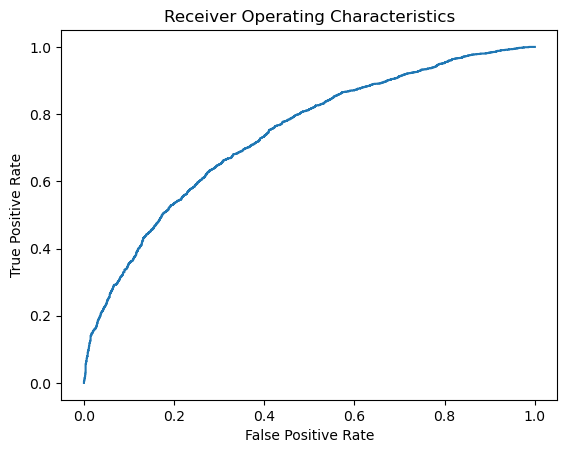

In [66]:
df = df.dropna()
df = df[~(df == .5).any(axis=1)]
# df = df[~(df == -20).any(axis=1)]
# df = df[(df['surface_Hard'] == 1.0)]
# df = df[(df['tourney_level'] == 6.0)]

# df = df.drop(df.columns[df.columns.str.contains('_rd')], axis=1)

odds_df = df[['a_odds', 'b_odds']].copy()
odds_df['index'] = df.index

df = df.drop(columns=['a_odds', 'b_odds', 'tourney_level'])

y = df['a_b_win'].values
X = df.drop('a_b_win', axis=1).values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, odds_df['index'].values, test_size=0.2, random_state=42
)

# Set target accuracy
target_accuracy = 0.733

final_acc = 0.0
while final_acc < target_accuracy:
    best_acc, best_auc, best_model_weights = cross_validate(NeuralNetwork, X_train, y_train, epochs=100, target_accuracy=target_accuracy)
    print(f"Best cross-validated accuracy: {best_acc*100:.2f}%")

    # Final training on full training data
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    val_data = TensorDataset(X_test_tensor, y_test_tensor)
    val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

    model = NeuralNetwork(input_dim=X.shape[1])
    model.load_state_dict(best_model_weights)
    final_auc, final_acc, _ = train_and_evaluate(model, train_loader, val_loader, epochs=100, target_accuracy=target_accuracy)
    print(f"Final model accuracy on test set: {final_acc*100:.2f}% AUC: {final_auc}")

    if final_acc < target_accuracy:
        print(f"Accuracy {final_acc*100:.2f}% not met, restarting the process.")
    # Quick train break
    break

# Evaluate and store predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_test_np = y_test_tensor.numpy()
    odds_test = odds_df.loc[idx_test].values

    # Create DataFrame with predictions and actual values
    results_df = pd.DataFrame({
        'Actual': y_test_np.flatten(),
        'Predicted': y_pred.flatten(),
        'A_Odds': odds_test[:, 0],
        'B_Odds': odds_test[:, 1]
    })

    # Optionally save to CSV
    results_df.to_csv('predictions_with_odds.csv', index=False)

# Plot ROC curve
with torch.no_grad():
    fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred)
    plt.plot(fpr, tpr)
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [67]:
# Display the DataFrame
# results_df.head()
print(results_df)

      Actual  Predicted  A_Odds  B_Odds
0        1.0   0.795555    1.09    7.71
1        0.0   0.562049    1.61    2.32
2        0.0   0.734655    1.27    3.68
3        0.0   0.430972    2.00    1.77
4        0.0   0.278432    3.13    1.35
...      ...        ...     ...     ...
4392     0.0   0.614176    1.63    2.28
4393     1.0   0.709369    1.47    2.67
4394     0.0   0.433925    2.36    1.59
4395     1.0   0.829714    1.14    5.55
4396     1.0   0.471721    2.19    1.66

[4397 rows x 4 columns]


In [68]:
# Kelly Criterion
def kelly_criterion(vegas_odds, calculated_probability):
    if calculated_probability <.5 :
        return 0
    corrected = vegas_odds - 1
    # Calculate the Kelly fraction
    kelly_fraction = calculated_probability - ((1 - calculated_probability)/corrected)
    # Ensure that the fraction is not negative
    kelly_fraction = max(0, kelly_fraction)
    
    return kelly_fraction

In [69]:
comparison_df = results_df.dropna()
new_df = pd.DataFrame(columns=comparison_df.columns)

for _, row in comparison_df.iterrows():
    kelly = kelly_criterion(row['A_Odds'], row['Predicted'])
    kelly2 = kelly_criterion(row['B_Odds'], 1 - row['Predicted'])
    if kelly > 0 or kelly2 > 0:
        new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)

print(new_df)

      Actual  Predicted  A_Odds  B_Odds
0        0.0   0.430972    2.00    1.77
1        0.0   0.433123    1.68    2.18
2        1.0   0.639317    1.61    2.33
3        0.0   0.528371    2.02    1.79
4        0.0   0.382515    2.21    1.66
...      ...        ...     ...     ...
1373     1.0   0.620841    1.77    2.00
1374     1.0   0.463536    1.56    2.43
1375     1.0   0.454017    1.70    2.12
1376     0.0   0.614176    1.63    2.28
1377     1.0   0.709369    1.47    2.67

[1378 rows x 4 columns]


/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_78705/3635430040.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


In [70]:
better = 0
total_won = 0
diff_fav = 0
bet_correct = 0

upset_predict = 0
upset_correct = 0
upset_won = 0

model_correct = 0
vegas_correct = 0
vegas_total = 0

wrong = 0
comparison_df = results_df.dropna()
length = len(comparison_df)

avg_bet = 0

confidence_pct = .7
confidence_top_pct = 1

START_UNIT = 10
UNIT = START_UNIT

for i, row in comparison_df.iterrows():
    current = START_UNIT
    if confidence_top_pct > row['Predicted'] > confidence_pct :
        kelly = (kelly_criterion(row['A_Odds'], row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['A_Odds'], row['Predicted'])
        if(row['Actual'] == 1):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['A_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if 1-confidence_top_pct < row['Predicted'] < 1-confidence_pct :
        kelly = (kelly_criterion(row['B_Odds'], 1-row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['B_Odds'], 1-row['Predicted'])
        if(row['Actual'] == 0):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['B_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if round(row['Predicted']) != round(1/row['A_Odds']):
        kelly_A  = (kelly_criterion(row['A_Odds'],row['Predicted']) * UNIT)
        kelly_B  = (kelly_criterion(row['B_Odds'],1-row['Predicted']) * UNIT)

        upset_predict += 1 if (kelly_A > 0 and round(row['Predicted']) == 1) or (kelly_B > 0 and round(row['Predicted']) == 0) else 0

        if round(row['Predicted']) == round(row['Actual']):
            if(row['Actual'] == 1):
                upset_correct += 1 if kelly_A > 0 else 0
                upset_won += 10 # (row['A_Odds']-1) * kelly_A
            else:
                upset_correct += 1 if kelly_B > 0 else 0
                upset_won += 10 # (row['B_Odds']-1) * kelly_B
        elif round(row['Predicted']) == 1:
            upset_won -= 10 # kelly_A
        else:
            upset_won -= 10 # kelly_B
            
    if round(row['Predicted']) != round(1/row['A_Odds']):
        diff_fav += 1

    if row['Actual']==1 and row['A_Odds'] < row['B_Odds']:
        # print(f"A odds : {row['a_odds']} B odds : {row['b_odds']}")
        vegas_correct += 1

    if row['Actual']==0 and row['A_Odds'] > row['B_Odds']:
        vegas_correct += 1

    if round(row['Predicted']) == round(row['Actual']):
        model_correct += 1


print(f"Total returned on Starting ${UNIT} bankroll: {START_UNIT:.2f} on a total # bets: {better} from a total of {length} games")
print(f"ROI : {((START_UNIT-UNIT)/UNIT):.1f} X")
print(f"Avg Bankroll Bet % : {(avg_bet/better):.3f} %")
print(f"Amount of differing favorites %: {(diff_fav/length):.3f}")
print(f"Amount of upset bets correct % : {(upset_correct/upset_predict):.3f} with Unit ${UNIT} won ${upset_won:.2f} on {upset_predict} bets")
print(f"Amount of incorrect bet % : {(wrong/better):.4f}")
print(f"Correct Bet %: {(bet_correct/better):.4f}")
print(f"Model % Correct : {(model_correct/length):.4f} Vegas Correct % : {(vegas_correct/length):.4f}")


Total returned on Starting $10 bankroll: 0.00 on a total # bets: 487 from a total of 4397 games
ROI : -1.0 X
Avg Bankroll Bet % : 0.201 %
Amount of differing favorites %: 0.129
Amount of upset bets correct % : 0.445 with Unit $10 won $-460.00 on 519 bets
Amount of incorrect bet % : 0.2895
Correct Bet %: 0.7105
Model % Correct : 0.6759 Vegas Correct % : 0.6918
